# Import all Dependecies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from keras.applications.vgg16 import VGG16
import os

# Set all the Constants

In [31]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=60

# Import data into tensorflow dataset object

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3237 files belonging to 5 classes.


In [4]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 929 files belonging to 5 classes.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/val",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 461 files belonging to 5 classes.


In [6]:
class_names= train_ds.class_names if train_ds.class_names==test_ds.class_names==val_ds.class_names else 'Classes don\'t match among train,test, and validation dataset'
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [7]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[3 2 2 2 1 0 1 1 2 1 1 1 1 2 1 1 1 1 2 0 1 0 1 3 2 1 0 0 0 4 1 1]


# SAMPLE

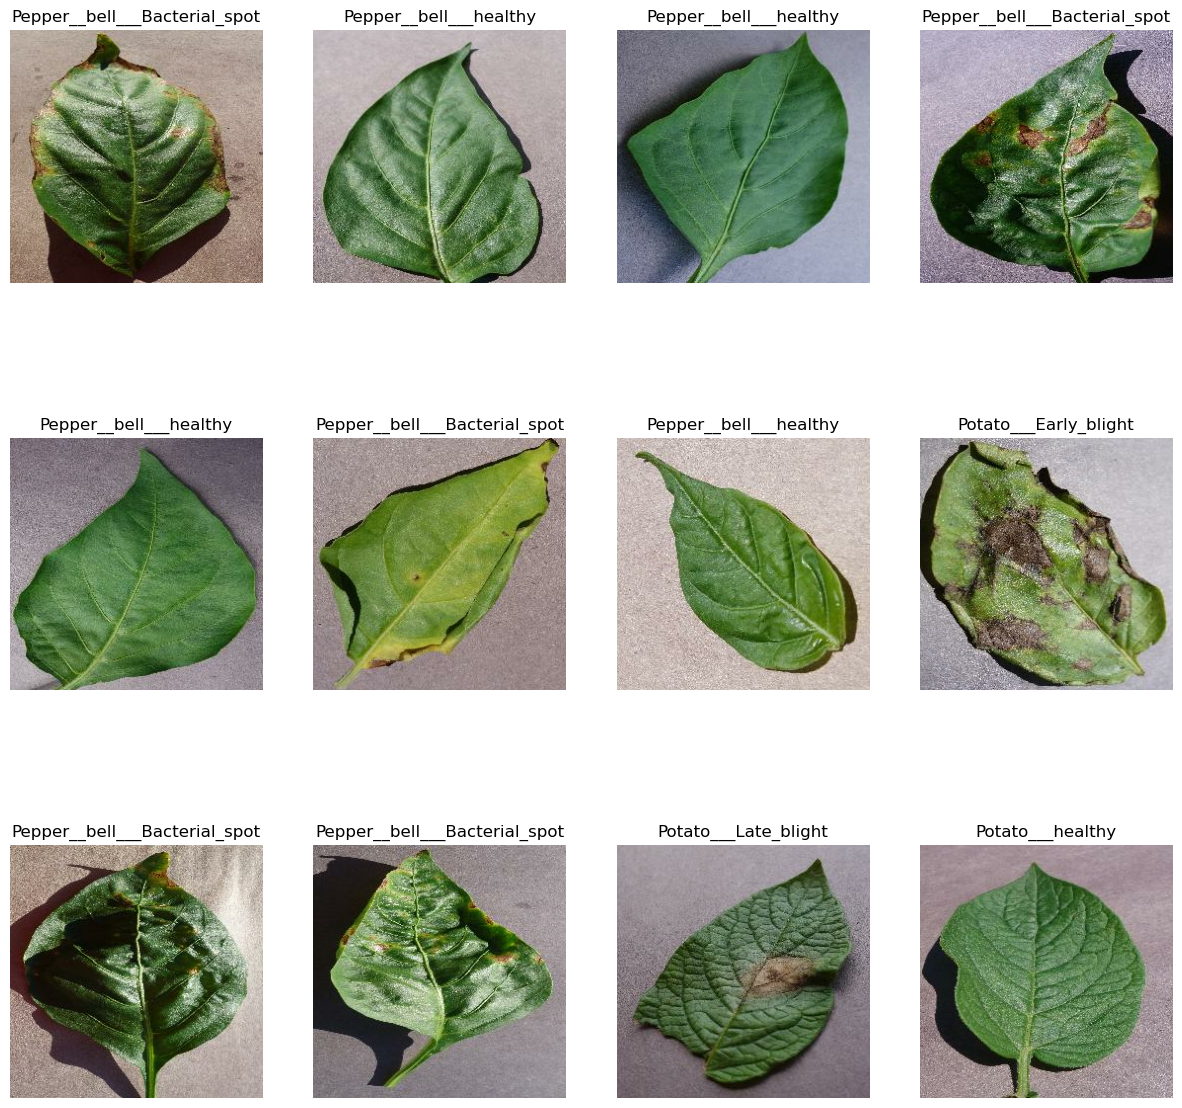

In [8]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# SPLIT DATASET

In [9]:
len(train_ds),len(val_ds),len(test_ds)

(102, 15, 30)

# Cache, Shuffle, and Prefetch the Dataset

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Creating a Layer for Resizing and Normalization

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

# Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


# Applying Data Augmentation to Train Dataset

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture

In [14]:
save_dir = '/Users/nasifsadiq/Go to files/BracU/Semester 12/CSE470/Project/compare/vgg16'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

In [15]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
model = models.Sequential()
for layer in base_model.layers:
    layer.trainable=False
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(n_classes, activation = 'softmax'))

model.build(input_shape=input_shape)

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=60,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/60
102/102 [==============================] - 42s 400ms/step - loss: 1.3741 - accuracy: 0.6228 - val_loss: 0.5044 - val_accuracy: 0.7983
Epoch 2/60


/Users/nasifsadiq/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


102/102 [==============================] - 41s 402ms/step - loss: 0.4042 - accuracy: 0.8576 - val_loss: 0.2882 - val_accuracy: 0.8959
Epoch 3/60
102/102 [==============================] - 41s 399ms/step - loss: 0.2692 - accuracy: 0.9033 - val_loss: 0.2303 - val_accuracy: 0.9132
Epoch 4/60
102/102 [==============================] - 41s 398ms/step - loss: 0.2142 - accuracy: 0.9203 - val_loss: 0.1688 - val_accuracy: 0.9349
Epoch 5/60
102/102 [==============================] - 41s 400ms/step - loss: 0.1735 - accuracy: 0.9357 - val_loss: 0.1470 - val_accuracy: 0.9523
Epoch 6/60
102/102 [==============================] - 41s 398ms/step - loss: 0.1632 - accuracy: 0.9435 - val_loss: 0.1781 - val_accuracy: 0.9262
Epoch 7/60
102/102 [==============================] - 41s 399ms/step - loss: 0.1376 - accuracy: 0.9478 - val_loss: 0.1214 - val_accuracy: 0.9588
Epoch 8/60
102/102 [==============================] - 41s 399ms/step - loss: 0.1245 - accuracy: 0.9571 - val_loss: 0.1374 - val_accuracy: 0.9

# Load Model

In [20]:
new_model=tf.keras.models.load_model("/Users/nasifsadiq/Go to files/BracU/Semester 12/CSE470/Project/compare/vgg16/checkpoint-57-0.04.h5")

In [21]:
scores = new_model.evaluate(test_ds)

30/30 [==============================] - 12s 362ms/step - loss: 0.0891 - accuracy: 0.9666


In [22]:
scores

[0.08913200348615646, 0.966630756855011]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 102}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
type(history.history['loss'])

list

In [27]:
len(history.history['loss'])

60

In [28]:
history.history['loss'][:5]

[1.3740676641464233,
 0.4041765630245209,
 0.26924148201942444,
 0.2141847312450409,
 0.17353977262973785]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

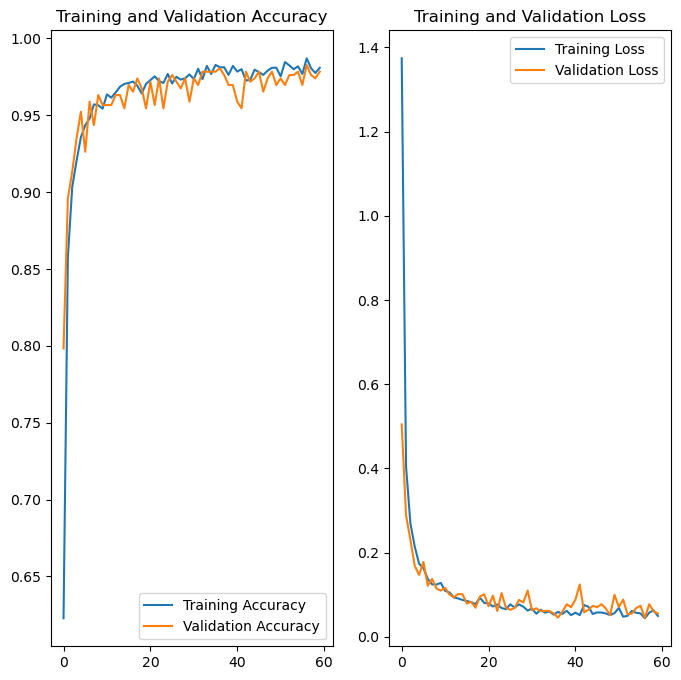

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 145ms/step
predicted label: Potato___Early_blight


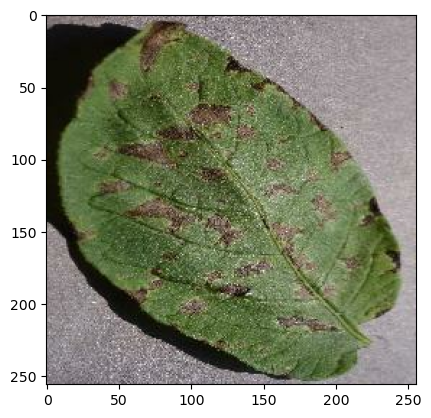

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 14ms/step


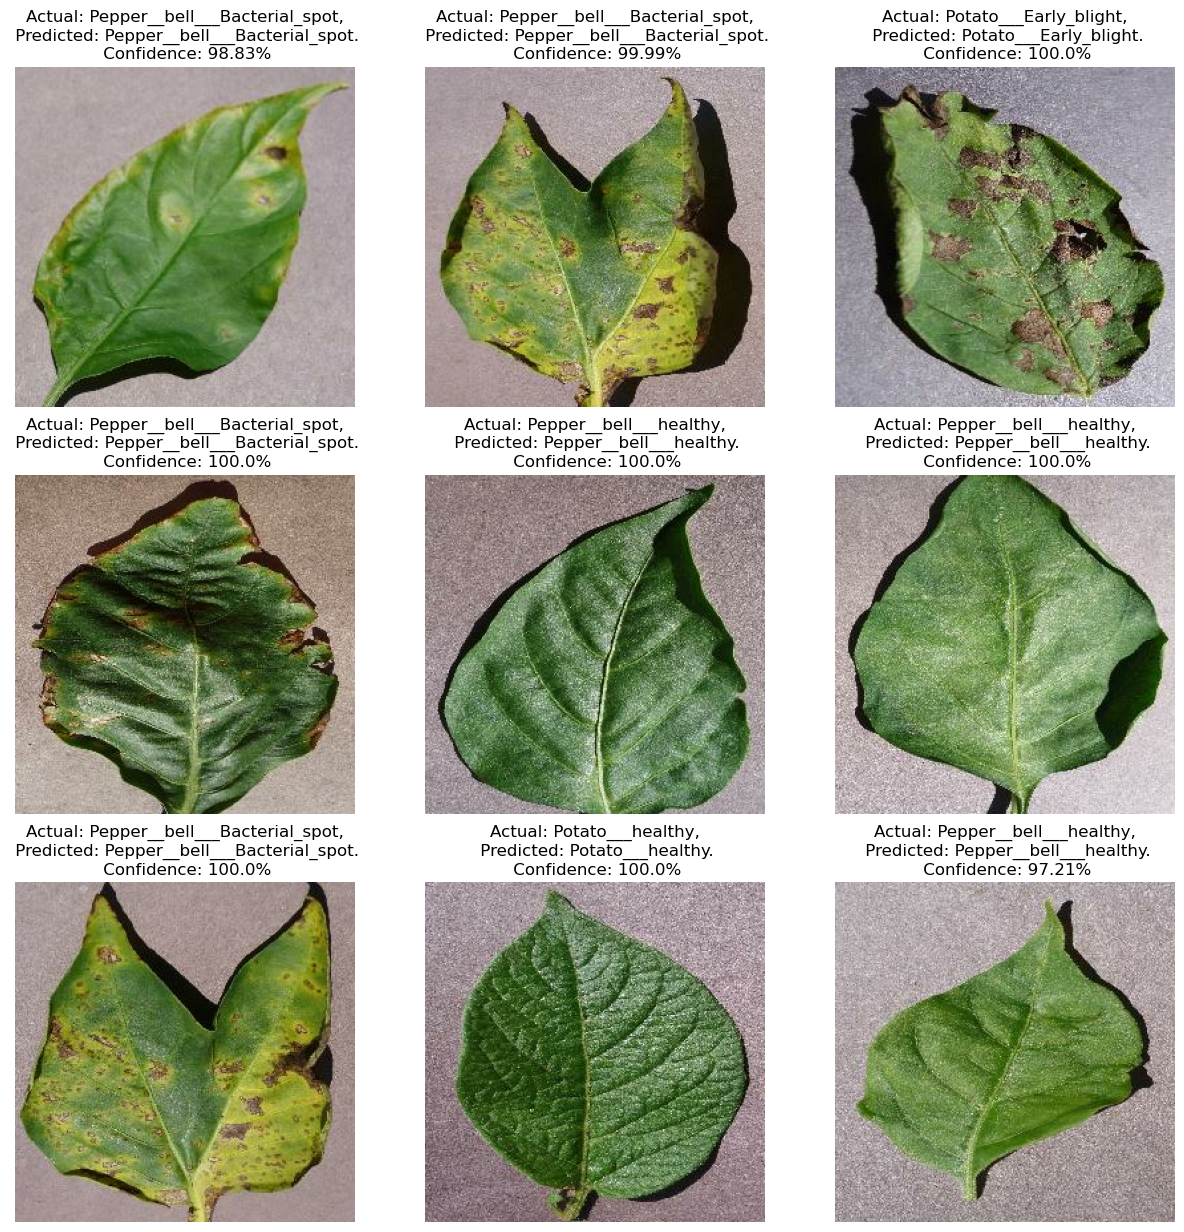

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")